# Quickstart

## Preparing a spectral `datacube` object

Let's initialise a `datacube` instance that will store the wavelength and flux.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from redcross import Datacube, CCF, KpV, Planet, Template

### Load data
We load an example file containing a set of HARPS-N frames and 9 of the central orders (33 to 41).


To follow the example download the FITS file from [link](https://drive.google.com/file/d/16ihuW_ppdtG89i6eXpROhsbFkXNex_O3/view?usp=sharing).
Or load your own data containing a *wavelength* vector (nOrders, nPixels) and a *flux* vector with shape 
(nOrders, nFrames, nPixels).

In [3]:
file = '/home/dario/AstronomyLeiden/MRP/redcross/examples/data/example_harpsn33_42.fits'

with fits.open(file) as hdul:
    wave = hdul[1].data
    flux = hdul[2].data
    header = hdul[3].data # this will be used in the Cross-Correlation
print('--Shape-- \n Wave = {:} \n Flux = {:}\n--------'.format(wave.shape, flux.shape))
print('{:} orders, {:} files, {:} pixel channels\n'.format(*flux.shape))
dc = Datacube(wlt=wave, flux=flux)


--Shape-- 
 Wave = (9, 4096) 
 Flux = (9, 247, 4096)
--------
9 orders, 247 files, 4096 pixel channels



### Display all orders
For each order, plot the master spectrum. Order 0 corresponds to order 33/69 of HARPS-N.

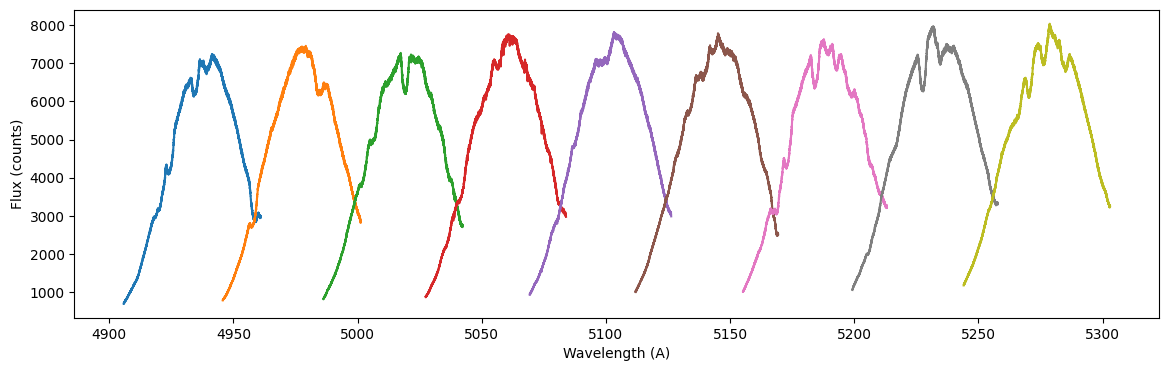

In [4]:
fig, ax = plt.subplots(1, figsize=(14,4))
for o in range(dc.nOrders):
    dco = dc.order(o).plot(ax=ax) # .plot() displays the time-average i.e. master-spectrum

ax.set(xlabel='Wavelength (A)', ylabel='Flux (counts)')
plt.show()

## Basic reduction
To manipulate the data, we will work with each order separately. To select an order simply call the function `datacube.order()`. If you want to store a single-order datacube `dco` call `dco=dc.order(INTEGER)` 

TypeError: sysrem() got an unexpected keyword argument 'ax'

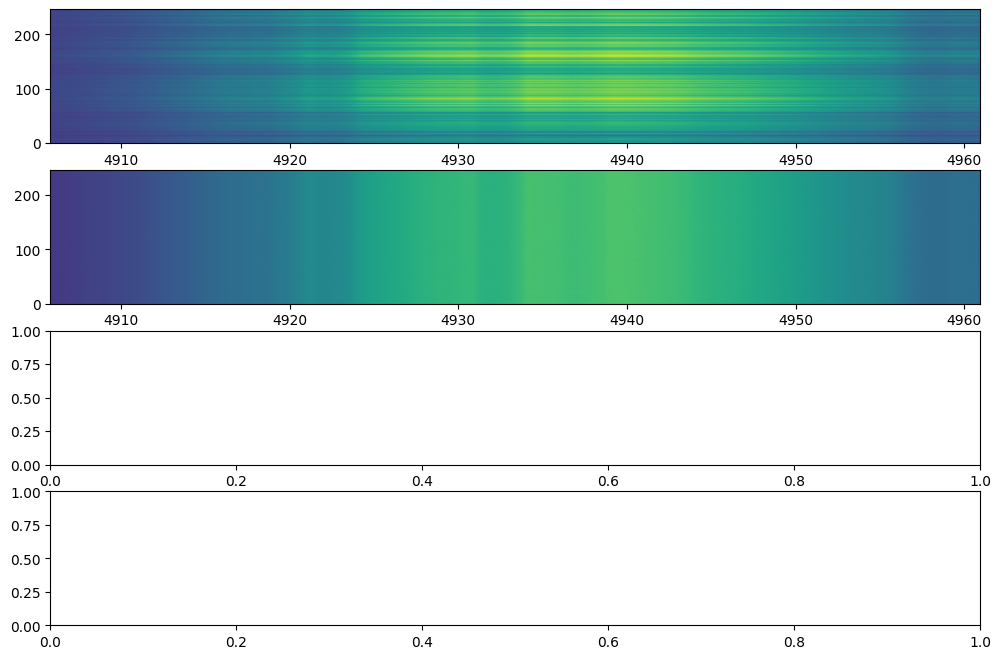

In [5]:
dco = dc.order(0)

fig, ax = plt.subplots(4, figsize=(12, 8))
dco.imshow(ax=ax[0])
dco.normalise(ax=ax[1]) # divide each frame by its mean value
dco.sysrem(5, ax=ax[2]) # run `n` iterations of the SysRem algorithm
dco.high_pass_gaussian(window=15, ax=ax[3]) # remove low-frequency variations
plt.show()

Now let's loop over all orders, the steps applied above can be concatenated in a single line

In [ ]:
nOrders = dc.shape[0]
for order in range(nOrders):
    print('Order {:}/{:}'.format(o, nOrders-1), end='\r')
    dco = dc.order(order) # select order
    dco.normalise().sysrem(5).high_pass_gaussian(15) # apply reduction routine
    dc.update(dco, order) # save data on the original datacube (or create a copy and update that one)

Before computing the CCF, we create a *new* datacube instance with all the orders merged

In [ ]:
dcm = dc.merge_orders()
print('New shape: ', dcm.shape)
dcm.imshow()
# the vertical (noisy) stripes are the left part of each order

## Cross-correlation
Compute the cross-correlation function (CCF) for each frame along the RV lag-vector to build a 2D CCF
> ```CCF.shape = (nFrames, nRV)```

The default definition of the CCF is
$$ 
CCF_{ij} = \frac{data_i \times template_j}{\sigma_i^2}
$$
where $i$ = 1,.., nFrame and $j$ = min(RV),.., max(RV) and $\sigma_i$ is the noise of each pixel channel (column).

### Load a template
The atmospheric template must have a *wavelength* vector in the same units as the data and the *flux* must be **normalised** (around 1.0). For this example we use the Fe template ([download here](https://github.com/DGonzalezPicos/redcross/blob/main/examples/data/wasp189_fe_4000k.fits)) generated with [petitRADTRANS](https://petitradtrans.readthedocs.io/en/latest/index.html).

In [ ]:
# from redcross.cross_correlation import CCF, KpV, Template

data_dir = '/home/dario/AstronomyLeiden/MRP/redcross/examples/data/' # EDIT WITH YOUR OWN PATH
template_path = data_dir + 'wasp189_fe_4000k.fits' 
with fits.open(template_path) as hdul:
    hdul.info()
    twave, tflux = hdul[0].data,  hdul[1].data

# 
template = Template(wlt=twave, flux=tflux)

fig, ax = plt.subplots(1, figsize=(10,4))
ax.plot(template.wlt, template.flux, c='navy', lw=0.2)
ax.set(xlabel='Wavelength (A)', ylabel='Normalised flux', title='Fe template')
plt.show()

### Shift to stellar frame
Apply the RV-barycentric correction by using the `BERV` header values. Every frame is shifted accoring to its BERV value and the data is resampled onto the new (shifted) wave vector.

In [ ]:
dcm.to_stellar_frame(header.BERV)

### Compute the CCF

In [ ]:
# define radial velocity lag vector
dRV = 1.6 # the RV-step should be larger (or equal) to the instrument's resolution (in km/s)
# HARPS-N: R ~ 115,000 ---> delta_RV ~ 1.6 km/s
RVt = np.arange(-350,351, dRV) 

# Define CCF object
ccf = CCF(rv=RVt, template=template)
ccf.run(dcm, weighted=True)

## Load planet data
To shift the CCF to the planetary rest-frame we load the planet's orbital parameters.
### 1. from a file (see `WASP189.dat` for an example)

```
planet_file = 'data/wasp33.dat' 
planet = Planet(file=planet_file) 
```

### 2. manually passing a dictionary

In [ ]:
# from redcross.planet import Planet
planet_dict = {'P':2.7240338, 'a':0.0497, 'i':84.32, 'v_sys':-20.82, 'Tc_jd':2456706.4558,
               'RA_DEG': 225.68695,'DEC_DEG': -3.0313833}
planet = Planet(**planet_dict)
planet.BERV = header.BERV
planet.MJD = header.MJD

### Shift the CCF to the planetary rest frame

In [ ]:
# Plot results from CCF in stellar and planetary frame
fig, ax = plt.subplots(3,1,figsize=(7,10))

ccf.imshow(ax=ax[0])
ccf_planet = ccf.to_planet_frame(planet, ax=ax[1])
ax[2].plot(ccf_planet.rv, np.median(ccf_planet.flux, axis=0))

ax[0].set(ylabel='Frame number', title='CCF-map in stellar rest frame')
ax[1].set(ylabel='Frame number', title='CCF-map in planetary rest frame')
ax[2].set(xlabel='RV (km/s)', ylabel='CCF value')
plt.show()

## Kp-Vsys map

This map is constructed by **adding** the values of the CCF along different paths by changing the $K_p$ and $V_{sys}$ values.
The planet signal should appear around $V_{sys} \sim $ 0 km/s if the passed $V_{sys}$ value is correct. The $K_p$ vector is automatically generated around the expected $K_p$ (with the planet orbital parameters):

$$ v_{orb} = 2\pi a / P \\ K_p = v_{orb} / \sin{i} $$

The instantaneous planet velocity is (in the **obs**erver's and **planet**'s reference frame):


$$ 
RV(t)_{obs} = V_{sys} + BERV + K_p \sin{\phi(t)} \\
RV(t)_{planet} = K_p \sin{\phi(t)} = RV(t)_{obs} - (V_{sys} + BERV)
$$ 


where $\phi$ is the phase ($\phi = 0$ at mid-transit `planet.Tc`).

In [ ]:
dkp, kp_amp = dRV, 50 # km/s
vrest_amp, dvrest = 80, dRV # km /s
kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)
kpv.run()
kpv.fancy_figure()
plt.show()
print('Expected planet Kp = {:.1f}'.format(planet.Kp))